# TITLE


### Issue

<>

### Solution

<>

### Related Work

The following papers include discussion of this topic:

- [LINK](LINK), AUTHORS, YEAR

### Related Discussion / Examples

The following examples discuss related topics:
-  [LINK](LINK), DESCRIPTION

In [ ]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import the model objects
from specparam import SpectralModel, SpectralGroupModel

# Import some utilities for creating simulated power-spectra and calculating error
from specparam.sim import sim_power_spectrum
from specparam.sim.utils import set_random_seed
from specparam.measures.error import compute_pointwise_error

# Import some utilities for simulating time series
from neurodsp.sim import sim_combined, sim_knee, sim_peak_oscillation, sim_powerlaw
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import create_times, set_random_seed

In [2]:
# Add path and import custom code for the project
import sys
sys.path.append('code')

### Settings

In [3]:

sns.set_context('poster')

In [4]:
# Set random seed
set_random_seed(42)

In [9]:
# Set whether to save out figures
SAVE_FIG = False

### OVERVIEW

### SECTION II TITLE

### Shorter Time Windows Will Typically Lead to Poorer Model Fits

First, we can simulate a time series with periodic and aperiodic components.

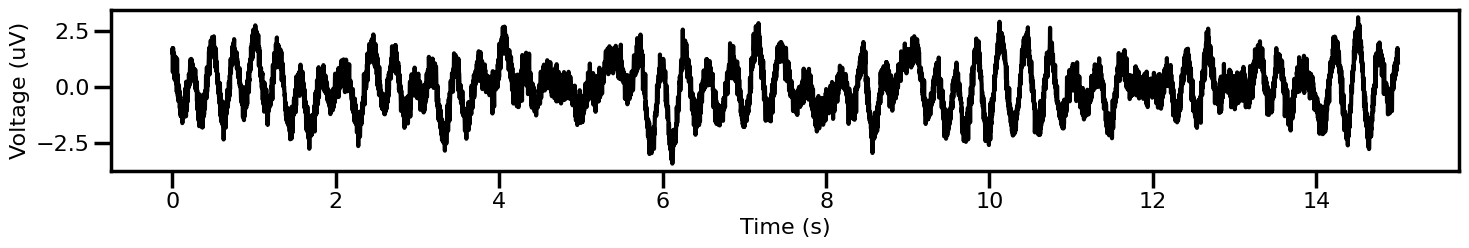

In [ ]:
# Simulate timeseries as a combination of aperiodic and periodic components + noise
sim_components = {'sim_knee': {'exponent1' : 0, 'exponent2':-5, 'knee':10},
                   'sim_oscillation': [{'freq' : 4}, {'freq' : 50}]}
fs = 1000
n_seconds = 15
ap_sig = sim_knee(n_seconds, fs,**sim_components['sim_knee'])
sig = sim_peak_oscillation(ap_sig, fs, freq=sim_components['sim_oscillation'][0]['freq'], bw=1, height=3)
sig = sim_peak_oscillation(sig, fs, freq=sim_components['sim_oscillation'][1]['freq'], bw=0.5, height=7)

# Add noise
noise = sim_powerlaw(n_seconds, fs, exponent=0, f_range=(0.1, 200))
sig = sig + 0.3 * noise

times = create_times(n_seconds=n_seconds, fs=fs)
plot_time_series(times, sig)

Compute the power spectrum for the entire signal with the simulated oscillation peaks highlighted

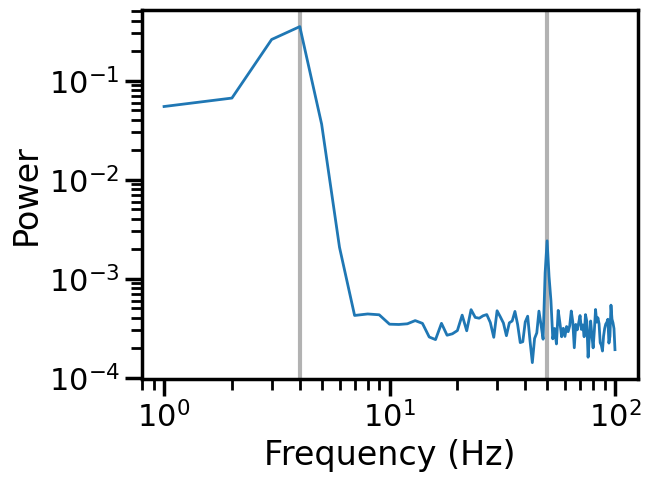

In [ ]:
# Compute the power spectrum using Welch's 
freqs, powers = compute_spectrum(sig, fs=fs, f_range=(0.1,100), avg_type='median', nperseg=fs, noverlap=fs/2)

plt.axvline(sim_components['sim_oscillation'][0]['freq'], color='k', alpha=0.3)
plt.axvline(sim_components['sim_oscillation'][1]['freq'], color='k', alpha=0.3)
plt.loglog(freqs,powers, linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.show()

You can fit this power spectrum of the entire signal and it fits fairly well, correctly identifying the oscillatory peaks and with a high r-squared (0.9437), and low error (0.1082). 


	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -3.1534,

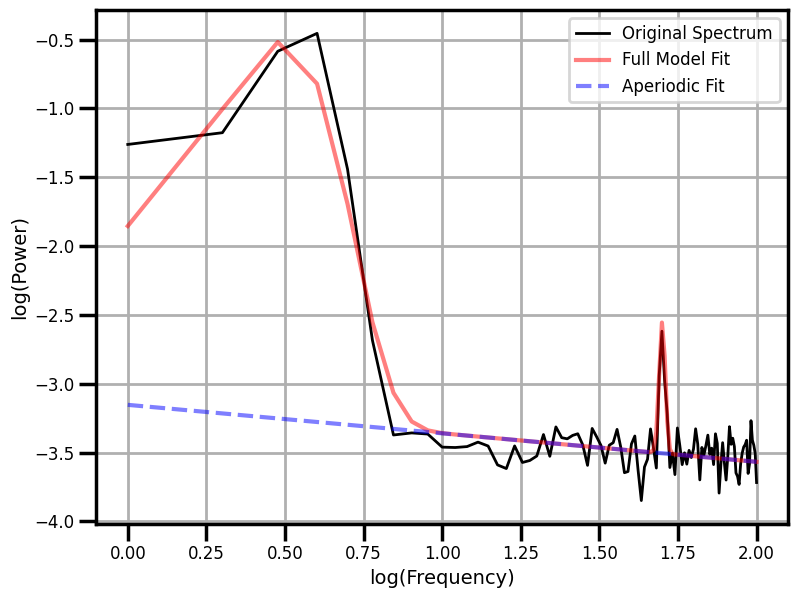

In [ ]:
fm = SpectralModel(peak_width_limits=[1, 8], max_n_peaks=3, min_peak_height=0.4)
fm.report(freqs, powers, freq_range=(0,100), plt_log=True)

Then, if you were interested in how these spectral parameters changed across the signal, you could do a sliding window approach, computing power spectra in 2-second windows with 50% overlap.

In [ ]:
win_len = int(2 * fs)
step = win_len//2  # 50% overlap

all_freqs = []
all_powers = []

for start in range(0, len(sig) - win_len + 1, step):
    seg = sig[start:start + win_len]

    freqs, powers = compute_spectrum(seg, fs=fs, f_range=(0.1, 200), avg_type='median', nperseg=fs, noverlap=fs // 2
    )

    all_freqs.append(freqs)
    all_powers.append(powers)

all_freqs = np.array(all_freqs)     # shape: (n_windows, n_freqs)
all_powers = np.array(all_powers)   # shape: (n_windows, n_freqs)

Example plot of the first four windows show a much noisier PSD

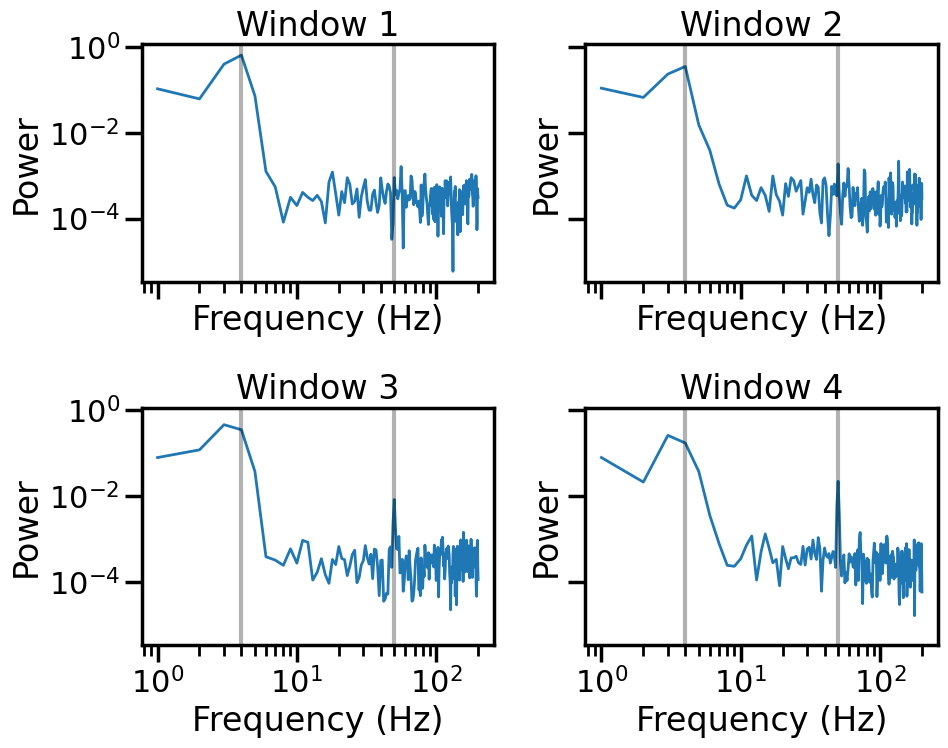

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
for window_i in range(4): # first 4 windows
    ax = axes.flatten()[window_i]
    ax.loglog(all_freqs[window_i], all_powers[window_i], linewidth=2)
    ax.set_title(f'Window {window_i+1}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    ax.axvline(sim_components['sim_oscillation'][0]['freq'], color='k', alpha=0.3)
    ax.axvline(sim_components['sim_oscillation'][1]['freq'], color='k', alpha=0.3)
plt.tight_layout()
plt.show()

When you fit these short-windowed spectra, it is noisier and misidentifies the higher frequency oscillation (50 Hz), and has a lower r-squared (0.7136), and higher error (0.2734). 


	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -3.7058, -0.

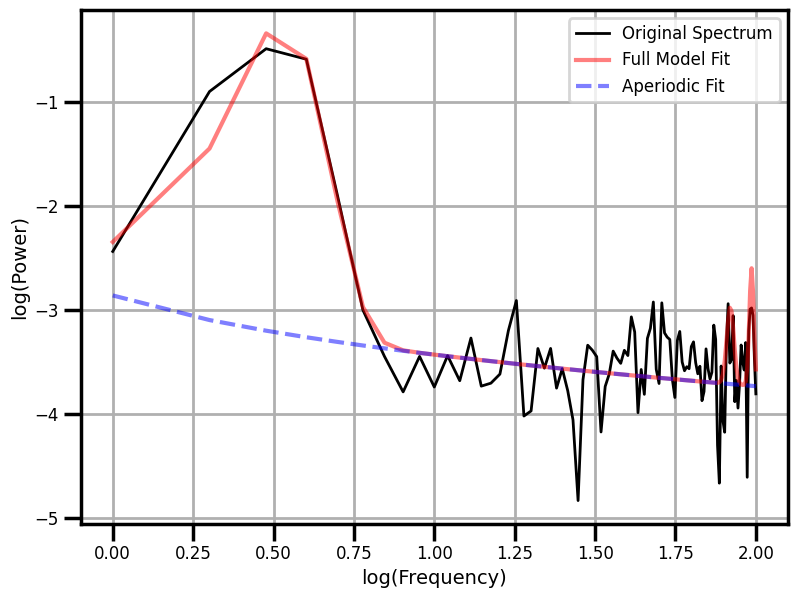

In [ ]:
fm = SpectralModel(peak_width_limits=[1, 8], max_n_peaks=3, min_peak_height=0.4, aperiodic_mode='knee')
fm.report(all_freqs[10], all_powers[10], freq_range=(0,100), plt_log=True)

### Conclusion

<>